In [737]:
import pandas as pd
from pandas import Timestamp as ts
import numpy as np
import seaborn as sns
import datetime as dt
import scipy as ss
import statsmodels as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
%matplotlib inline

In [738]:
# Выгружаю датафреймы

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = ['https://disk.yandex.ru/d/FUi5uSd6BfG_ig', 'https://disk.yandex.ru/d/t9Li4JOfgxuUrg', 'https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw']                # ссылки на данные

file_names = ['olist_customers_dataset.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv']
datasets = ['olist_customers_dataset_df', 'olist_orders_dataset_df', 'olist_order_items_dataset_df']

for i in range(3):
    final_url = base_url + urlencode(dict(public_key=public_key[i]))
    response = requests.get(final_url)
    download_url = response.json()['href']
    globals()[datasets[i]] = pd.read_csv(download_url)

## Проект e-commerce: вариант 1 
Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

#### 1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

#### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

#### 3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

#### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

#### 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

#### 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

Файлы:

 #### olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

#### olist_orders_dataset.csv —  таблица заказов
order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

#### olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан
approved —  подтверждён
invoiced —  выставлен счёт
processing —  в процессе сборки заказа
shipped —  отгружен со склада
delivered —  доставлен пользователю
unavailable —  недоступен
canceled —  отменён

In [120]:
# customer_id — позаказный идентификатор пользователя
# customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
# customer_zip_code_prefix —  почтовый индекс пользователя
# customer_city —  город доставки пользователя
# customer_state —  штат доставки пользователя

olist_customers_dataset_df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [121]:
# Смотрю на количество уникальных элементов 
olist_customers_dataset_df.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [122]:
# order_id —  уникальный идентификатор заказа (номер чека)
# customer_id —  позаказный идентификатор пользователя
# order_status —  статус заказа
# order_purchase_timestamp —  время создания заказа
# order_approved_at —  время подтверждения оплаты заказа
# order_delivered_carrier_date —  время передачи заказа в логистическую службу
# order_delivered_customer_date —  время доставки заказа
# order_estimated_delivery_date —  обещанная дата доставки

olist_orders_dataset_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [123]:
# order_id —  уникальный идентификатор заказа (номер чека)
# order_item_id —  идентификатор товара внутри одного заказа
# product_id —  ид товара (аналог штрихкода)
# seller_id — ид производителя товара
# shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
# price —  цена за единицу товара
# freight_value —  вес товара

olist_order_items_dataset_df

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [124]:
# Проверяю форматы колонок
olist_customers_dataset_df.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [125]:
# Проверяю форматы колонок
olist_orders_dataset_df.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [126]:
# Перевод в формат даты
olist_orders_dataset_df['order_purchase_timestamp'] = pd.to_datetime(olist_orders_dataset_df['order_purchase_timestamp'])
olist_orders_dataset_df['order_approved_at'] = pd.to_datetime(olist_orders_dataset_df['order_approved_at'])
olist_orders_dataset_df['order_delivered_carrier_date'] = pd.to_datetime(olist_orders_dataset_df['order_delivered_carrier_date'])
olist_orders_dataset_df['order_delivered_customer_date'] = pd.to_datetime(olist_orders_dataset_df['order_delivered_customer_date'])
olist_orders_dataset_df['order_estimated_delivery_date'] = pd.to_datetime(olist_orders_dataset_df['order_estimated_delivery_date'])
olist_order_items_dataset_df['shipping_limit_date'] = pd.to_datetime(olist_order_items_dataset_df['shipping_limit_date'])

In [127]:
# Уточняю форматы колонок
olist_orders_dataset_df.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [128]:
# Уточняю форматы колонок
olist_order_items_dataset_df.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [129]:
# Промежуточный татафрейм
tmp_df = olist_orders_dataset_df.merge(olist_order_items_dataset_df, how='right', on='order_id')
tmp_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [130]:
all_info_df = olist_customers_dataset_df.merge(tmp_df, how='right', on='customer_id')

In [131]:
# Объеденил все датафреймы 
all_info_df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,00010242fe8c5a6d1ba2dd792cb16214,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,00018f77f2f0320c557190d7a144bdd3,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,000229ec398224ef6ca0657da4fc703e,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,00024acbcdf0a6daa1e931b038114c75,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,00042b26cf59d7ce69dfabb4e55b4fd9,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,b51593916b4b8e0d6f66f2ae24f2673d,0c9aeda10a71f369396d0c04dce13a64,65077,sao luis,MA,fffc94f6ce00a00581880bf54a75a037,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,84c5d4fbaf120aae381fad077416eaa0,0da9fe112eae0c74d3ba1fe16de0988b,81690,curitiba,PR,fffcd46ef2263f404302a634eb57f7eb,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,29309aa813182aaddc9b259e31b870e6,cd79b407828f02fdbba457111c38e4c4,4039,sao paulo,SP,fffce4705a9662cd70adb13d4a31832d,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,b5e6afd5a41800fdf401e0272ca74655,eb803377c9315b564bdedad672039306,13289,vinhedo,SP,fffe18544ffabc95dfada21779c9644f,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [132]:
# Смотрю на количество пропущенных полей
all_info_df.isna().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
dtype: int64

In [133]:
# Проверка на дупликаты
all_info_df.drop_duplicates()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,00010242fe8c5a6d1ba2dd792cb16214,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,00018f77f2f0320c557190d7a144bdd3,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,000229ec398224ef6ca0657da4fc703e,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,00024acbcdf0a6daa1e931b038114c75,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,00042b26cf59d7ce69dfabb4e55b4fd9,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,b51593916b4b8e0d6f66f2ae24f2673d,0c9aeda10a71f369396d0c04dce13a64,65077,sao luis,MA,fffc94f6ce00a00581880bf54a75a037,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,84c5d4fbaf120aae381fad077416eaa0,0da9fe112eae0c74d3ba1fe16de0988b,81690,curitiba,PR,fffcd46ef2263f404302a634eb57f7eb,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,29309aa813182aaddc9b259e31b870e6,cd79b407828f02fdbba457111c38e4c4,4039,sao paulo,SP,fffce4705a9662cd70adb13d4a31832d,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,b5e6afd5a41800fdf401e0272ca74655,eb803377c9315b564bdedad672039306,13289,vinhedo,SP,fffe18544ffabc95dfada21779c9644f,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


Статусы говорящие о том, что товар не был куплен (т.к. эти значения указывают на прямое влияние самого клента)

created, 
unavailable, 
canceled

## 1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

In [134]:
all_info_df.query('order_status != "created" and order_status != "unavailable" and order_status != "canceled"').groupby('customer_unique_id').agg({'order_id':'count'}).query('order_id == 1').count()

order_id    83179
dtype: int64

### 83179
Тут я посчитал количество чеков на каждого уникального пользователя и отсеил неуникальные

## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

In [135]:
# Датафрейм со временем исполнения заказов
order_delivery_time_df = olist_orders_dataset_df 

In [136]:
# Проверка на уникальность
order_delivery_time_df.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [21]:
# Перевожу поля со временем в соответсвтужющий формат
order_delivery_time_df['order_purchase_timestamp'] = pd.to_datetime(order_delivery_time_df['order_purchase_timestamp'])
order_delivery_time_df['order_approved_at'] = pd.to_datetime(order_delivery_time_df['order_approved_at'])
order_delivery_time_df['order_delivered_carrier_date'] = pd.to_datetime(order_delivery_time_df['order_delivered_carrier_date'])
order_delivery_time_df['order_delivered_customer_date'] = pd.to_datetime(order_delivery_time_df['order_delivered_customer_date'])
order_delivery_time_df['order_estimated_delivery_date'] = pd.to_datetime(order_delivery_time_df['order_estimated_delivery_date'])

In [22]:
# Отсеил доставленные
order_delivery_time_df = order_delivery_time_df.query('order_status != "delivered"')

In [23]:
order_delivery_time_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07
...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaT,NaT,2018-02-06
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


 ### Идея в следующем: Я оставлю толькло те заказы, которые не пришли и сгруппирую по причине

In [24]:
# Тут видно, что большинство заказов имеют статус доставки. Скорее всего эти заказы не доставлены в указаные сроки
order_delivery_time_df.order_status.value_counts()

shipped        1107
canceled        625
unavailable     609
invoiced        314
processing      301
created           5
approved          2
Name: order_status, dtype: int64

In [25]:
# Ориентироваться буду на обещанную дату доставки
order_delivery_time_df['promised_year_and_month_of_delivery'] = order_delivery_time_df.order_estimated_delivery_date.astype("datetime64[M]")

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
# количество недоставленных заказов
number_of_undelivered_orders_df = order_delivery_time_df.groupby(['order_status', 'promised_year_and_month_of_delivery']).agg({'order_id':'count'})

In [27]:
number_of_undelivered_orders_df = number_of_undelivered_orders_df.reset_index()
number_of_undelivered_orders_df = number_of_undelivered_orders_df.rename(columns={'order_id':'order_count'})
# Отбираю тролько месяц
number_of_undelivered_orders_df['promised_month_of_delivery'] = number_of_undelivered_orders_df.promised_year_and_month_of_delivery.dt.month

In [28]:
number_of_undelivered_orders_df

,order_status,promised_year_and_month_of_delivery,order_count,promised_month_of_delivery
0,approved,2017-03-01,1,3
1,approved,2017-05-01,1,5
2,canceled,2016-09-01,1,9
3,canceled,2016-10-01,3,10
4,canceled,2016-11-01,14,11
...,...,...,...,...
110,unavailable,2018-04-01,11,4
111,unavailable,2018-05-01,12,5
112,unavailable,2018-06-01,7,6
113,unavailable,2018-07-01,7,7


In [29]:
# Вывожу сколько в среднем не доставляется в месяц и группирую по причинам
number_of_undelivered_orders_df = number_of_undelivered_orders_df.groupby(['order_status']).agg({'order_count':'mean'}).sort_values('order_count', ascending = False)
number_of_undelivered_orders_df

,order_count
order_status,
shipped,48.130435
unavailable,29.000000
canceled,24.038462
processing,15.842105
invoiced,14.952381
created,1.666667
approved,1.000000


## 3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

In [709]:
# Датафрейм с покупками
# 'order_status != "created" or order_status != "unavailable" or order_status != "canceled"'
unsuitable_statuses = ['created', 'unavailable', 'canceled']
all_purchases_df = all_info_df.copy().query('order_status not in @unsuitable_statuses')
source_for_weekly_purchases_df = all_purchases_df

In [710]:
all_purchases_df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,00010242fe8c5a6d1ba2dd792cb16214,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,00018f77f2f0320c557190d7a144bdd3,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,000229ec398224ef6ca0657da4fc703e,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,00024acbcdf0a6daa1e931b038114c75,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,00042b26cf59d7ce69dfabb4e55b4fd9,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,b51593916b4b8e0d6f66f2ae24f2673d,0c9aeda10a71f369396d0c04dce13a64,65077,sao luis,MA,fffc94f6ce00a00581880bf54a75a037,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,84c5d4fbaf120aae381fad077416eaa0,0da9fe112eae0c74d3ba1fe16de0988b,81690,curitiba,PR,fffcd46ef2263f404302a634eb57f7eb,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,29309aa813182aaddc9b259e31b870e6,cd79b407828f02fdbba457111c38e4c4,4039,sao paulo,SP,fffce4705a9662cd70adb13d4a31832d,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,b5e6afd5a41800fdf401e0272ca74655,eb803377c9315b564bdedad672039306,13289,vinhedo,SP,fffe18544ffabc95dfada21779c9644f,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [696]:
# Беру датафрем с покупками
order_delivery_time_df = all_purchases_df.copy()
order_delivery_time_df['order_purchase_timestamp'] = pd.to_datetime(order_delivery_time_df['order_purchase_timestamp'])
order_delivery_time_df['order_approved_at'] = pd.to_datetime(order_delivery_time_df['order_approved_at'])
order_delivery_time_df['order_delivered_carrier_date'] = pd.to_datetime(order_delivery_time_df['order_delivered_carrier_date'])
order_delivery_time_df['order_delivered_customer_date'] = pd.to_datetime(order_delivery_time_df['order_delivered_customer_date'])
order_delivery_time_df['order_estimated_delivery_date'] = pd.to_datetime(order_delivery_time_df['order_estimated_delivery_date'])
order_delivery_time_df['shipping_limit_date'] = pd.to_datetime(order_delivery_time_df['shipping_limit_date'])

In [697]:
# Проверка уникальных значений 
order_delivery_time_df.nunique()

customer_id                      98199
customer_unique_id               94983
customer_zip_code_prefix         14964
customer_city                     4109
customer_state                      27
order_id                         98199
order_status                         5
order_purchase_timestamp         97647
order_approved_at                89757
order_delivered_carrier_date     80950
order_delivered_customer_date    95658
order_estimated_delivery_date      447
order_item_id                       21
product_id                       32729
seller_id                         3053
shipping_limit_date              92883
price                             5934
freight_value                     6985
dtype: int64

In [698]:
# Создаю колонку с днем недели покупки
order_delivery_time_df['weekday'] = order_delivery_time_df.order_purchase_timestamp.dt.day_name()


In [699]:
order_delivery_time_df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,weekday
0,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,00010242fe8c5a6d1ba2dd792cb16214,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,Wednesday
1,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,00018f77f2f0320c557190d7a144bdd3,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,Wednesday
2,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,000229ec398224ef6ca0657da4fc703e,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,Sunday
3,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,00024acbcdf0a6daa1e931b038114c75,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,Wednesday
4,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,00042b26cf59d7ce69dfabb4e55b4fd9,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,b51593916b4b8e0d6f66f2ae24f2673d,0c9aeda10a71f369396d0c04dce13a64,65077,sao luis,MA,fffc94f6ce00a00581880bf54a75a037,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,Monday
112646,84c5d4fbaf120aae381fad077416eaa0,0da9fe112eae0c74d3ba1fe16de0988b,81690,curitiba,PR,fffcd46ef2263f404302a634eb57f7eb,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,Saturday
112647,29309aa813182aaddc9b259e31b870e6,cd79b407828f02fdbba457111c38e4c4,4039,sao paulo,SP,fffce4705a9662cd70adb13d4a31832d,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,Monday
112648,b5e6afd5a41800fdf401e0272ca74655,eb803377c9315b564bdedad672039306,13289,vinhedo,SP,fffe18544ffabc95dfada21779c9644f,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,Monday


In [700]:
# В order_delivery_time_df_tmp смотрю сколько раз упаминается неделя 
order_delivery_time_df_tmp = order_delivery_time_df.groupby(['product_id','weekday']).agg({'weekday':'count'}).rename(columns={'weekday':'weekday_count'})
order_delivery_time_df_tmp = order_delivery_time_df_tmp.reset_index()
weekly_df = order_delivery_time_df_tmp
order_delivery_time_df_tmp

,product_id,weekday,weekday_count
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
60885,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
60886,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1
60887,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
60888,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2


In [705]:
# Сортирую order_delivery_time_df_tmp поубыванию и удаляю дубликаты по product_id тем самым оставляя максимальные значения упоминания дня недели
order_delivery_time_df_tmp = order_delivery_time_df_tmp.groupby(['product_id','weekday']).agg({'weekday_count':'max'}).sort_values('weekday_count', ascending = False).reset_index()
weekly_df = order_delivery_time_df_tmp.drop_duplicates('product_id').set_index('product_id').drop('weekday_count',axis=1)
weekly_df

,weekday
product_id,
422879e10f46682990de24d770e7f83d,Wednesday
99a4788cb24856965c36a24e339b6058,Monday
aca2eb7d00ea1a7b8ebd4e68314663af,Thursday
53b36df67ebb7c41585e8d54d6772e08,Tuesday
368c6c730842d78016ad823897a372db,Friday
...,...
642e125cbc752b4eeb8faf442319c39f,Thursday
6432d844f2be41bb6f2fd279e23415da,Friday
6435535083cf42eb1ce5d96f2c4d3482,Tuesday


## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

In [707]:
# Беру датафрем с покупками
source_for_weekly_purchases_df = all_purchases_df.copy()

Нужные поля:

customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

order_id —  уникальный идентификатор заказа (номер чека)

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа


In [50]:
# За заказ человеком буду считать статусы кроме этих
# created 
# unavailable 
# canceled

source_for_weekly_purchases_df = source_for_weekly_purchases_df.drop(['customer_zip_code_prefix', 'customer_city', 'customer_state', 'order_status', 'order_estimated_delivery_date', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'order_item_id','product_id'], axis= 1)

In [51]:
source_for_weekly_purchases_df

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
0,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48
1,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24
2,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16
3,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39
4,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31
...,...,...,...,...,...,...,...
112645,b51593916b4b8e0d6f66f2ae24f2673d,0c9aeda10a71f369396d0c04dce13a64,fffc94f6ce00a00581880bf54a75a037,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40
112646,84c5d4fbaf120aae381fad077416eaa0,0da9fe112eae0c74d3ba1fe16de0988b,fffcd46ef2263f404302a634eb57f7eb,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55
112647,29309aa813182aaddc9b259e31b870e6,cd79b407828f02fdbba457111c38e4c4,fffce4705a9662cd70adb13d4a31832d,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22
112648,b5e6afd5a41800fdf401e0272ca74655,eb803377c9315b564bdedad672039306,fffe18544ffabc95dfada21779c9644f,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40


In [52]:
# добавляем колонку создания заказа в формате "год-месяц"
source_for_weekly_purchases_df['year_month_order'] = source_for_weekly_purchases_df.order_purchase_timestamp.astype("datetime64[M]")

In [53]:
# группирую по году-месяцу и пользователю и считаю количество покупок на пользователя в месяц
result_source_for_weekly_purchases_df = source_for_weekly_purchases_df.groupby(['year_month_order', 'customer_unique_id'], as_index=False).agg({'order_purchase_timestamp': 'count'})
result_source_for_weekly_purchases_df.sort_values('order_purchase_timestamp', ascending = False)

,year_month_order,customer_unique_id,order_purchase_timestamp
95482,2018-08-01,c8460e4251689ba205045f3ea17884a1,24
15430,2017-07-01,4546caea018ad8c692964e3382debd19,21
55997,2018-02-01,c402f431464c72e27330a67f7b94d4fb,20
20027,2017-08-01,698e1cf81d01a3d389d96145f7fa6df8,20
31515,2017-11-01,0f5ac8d5c31de21d2f25e24be15bbffb,18
...,...,...,...
35453,2017-11-01,9798ef74fb0730b4c3012fa25ac96c60,1
35452,2017-11-01,979851d650459bc5f67ad8ebccd5829a,1
35451,2017-11-01,9770456b4233cdf2363287ca2295650a,1
35450,2017-11-01,975da430d73b2d8b52bdb335a32b5a3f,1


In [54]:
# week_in_month - количество недель в месяце
result_source_for_weekly_purchases_df['week_in_month'] = source_for_weekly_purchases_df.order_approved_at.dt.days_in_month / 7

In [55]:
# pays_per_week - количество покупок в неделю
result_source_for_weekly_purchases_df['pays_per_week'] = result_source_for_weekly_purchases_df.order_purchase_timestamp / result_source_for_weekly_purchases_df.week_in_month
result_source_for_weekly_purchases_df = result_source_for_weekly_purchases_df.drop(['order_purchase_timestamp', 'week_in_month'], axis = 1).set_index('customer_unique_id')

In [56]:
result_source_for_weekly_purchases_df

,year_month_order,pays_per_week
customer_unique_id,,
830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-01,0.700000
b7d76e111c89f7ebf14761390f0f7d17,2016-09-01,0.466667
0032c76b20340da25249092a268ce66c,2016-10-01,0.225806
01f156677184504063bd19739f924af1,2016-10-01,0.225806
0313291a6f4f16df04dcf819d88c38ef,2016-10-01,0.250000
...,...,...
ffc4e1cd8aa220763480d0a18157c45d,2018-08-01,0.225806
ffe204b1bb8026741b839085b2fd10f2,2018-08-01,0.225806
ffec490ab531184a483efe2eedd68908,2018-08-01,0.225806


## 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

In [57]:
# Если перевести дословно у какой из группы на третий месяц вернулось больше всего человек

Беру датафрейм с покупками

In [711]:
tmp_df = all_purchases_df.copy()
tmp_df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,00010242fe8c5a6d1ba2dd792cb16214,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,00018f77f2f0320c557190d7a144bdd3,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,000229ec398224ef6ca0657da4fc703e,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,00024acbcdf0a6daa1e931b038114c75,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,00042b26cf59d7ce69dfabb4e55b4fd9,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,b51593916b4b8e0d6f66f2ae24f2673d,0c9aeda10a71f369396d0c04dce13a64,65077,sao luis,MA,fffc94f6ce00a00581880bf54a75a037,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,84c5d4fbaf120aae381fad077416eaa0,0da9fe112eae0c74d3ba1fe16de0988b,81690,curitiba,PR,fffcd46ef2263f404302a634eb57f7eb,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,29309aa813182aaddc9b259e31b870e6,cd79b407828f02fdbba457111c38e4c4,4039,sao paulo,SP,fffce4705a9662cd70adb13d4a31832d,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,b5e6afd5a41800fdf401e0272ca74655,eb803377c9315b564bdedad672039306,13289,vinhedo,SP,fffe18544ffabc95dfada21779c9644f,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [89]:
# validity_date - Дата создания заказа
tmp_df['validity_date'] = tmp_df.order_purchase_timestamp.dt.to_period('M')
tmp_df.head()


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,validity_date
0,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,00010242fe8c5a6d1ba2dd792cb16214,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09
1,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,00018f77f2f0320c557190d7a144bdd3,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04
2,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,000229ec398224ef6ca0657da4fc703e,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01
3,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,00024acbcdf0a6daa1e931b038114c75,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08
4,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,00042b26cf59d7ce69dfabb4e55b4fd9,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02


In [712]:
tmp_df.set_index('customer_unique_id', inplace=True) #добавим индекс в dataFrame по customer_unique_id
tmp_df['cohort'] = tmp_df.groupby(level=0)['order_purchase_timestamp'].min().dt.to_period('M') #добавим столбец с когортами
tmp_df.reset_index(inplace=True) #переиндексируем df
tmp_df

,customer_unique_id,customer_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,cohort
0,871766c5855e863f6eccc05f988b23cb,3ce436f183e68e07877b285a838db11a,28013,campos dos goytacazes,RJ,00010242fe8c5a6d1ba2dd792cb16214,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09
1,eb28e67c4c0b83846050ddfb8a35d051,f6dd3ec061db4e3987629fe6b26e5cce,15775,santa fe do sul,SP,00018f77f2f0320c557190d7a144bdd3,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04
2,3818d81c6709e39d06b2738a8d3a2474,6489ae5e4333f3693df5ad4372dab6d3,35661,para de minas,MG,000229ec398224ef6ca0657da4fc703e,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01
3,af861d436cfc08b2c2ddefd0ba074622,d4eb9395c8c0431ee92fce09860c5a06,12952,atibaia,SP,00024acbcdf0a6daa1e931b038114c75,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08
4,64b576fb70d441e8f1b2d7d446e483c5,58dbd0b2d70206bf40e62cd34e84d795,13226,varzea paulista,SP,00042b26cf59d7ce69dfabb4e55b4fd9,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112096,0c9aeda10a71f369396d0c04dce13a64,b51593916b4b8e0d6f66f2ae24f2673d,65077,sao luis,MA,fffc94f6ce00a00581880bf54a75a037,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,2018-04
112097,0da9fe112eae0c74d3ba1fe16de0988b,84c5d4fbaf120aae381fad077416eaa0,81690,curitiba,PR,fffcd46ef2263f404302a634eb57f7eb,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,2018-07
112098,cd79b407828f02fdbba457111c38e4c4,29309aa813182aaddc9b259e31b870e6,4039,sao paulo,SP,fffce4705a9662cd70adb13d4a31832d,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,2017-10
112099,eb803377c9315b564bdedad672039306,b5e6afd5a41800fdf401e0272ca74655,13289,vinhedo,SP,fffe18544ffabc95dfada21779c9644f,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,2017-08


In [91]:
# Создаю группу
grouped = tmp_df.groupby(['cohort', 'validity_date'])

# количество уникальных пользователей на дату создания заказа
cohorts_df = grouped.agg({'customer_unique_id': pd.Series.nunique}).rename(columns=({'customer_unique_id':'unique_users'})).reset_index()
cohorts_df

,cohort,validity_date,unique_users
0,2016-09,2016-09,2
1,2016-10,2016-10,287
2,2016-10,2017-04,1
3,2016-10,2017-07,1
4,2016-10,2017-09,1
...,...,...,...
215,2018-06,2018-08,16
216,2018-07,2018-07,6017
217,2018-07,2018-08,31
218,2018-08,2018-08,6209


In [713]:
# Группа будет выражаться через разницу в месяцах
cohorts_df['group_number'] = cohorts_df.validity_date.sub(cohorts_df.cohort).apply(attrgetter('n')) # Группа будет выражаться через разницу в месяцах
cohorts_df

,cohort,validity_date,unique_users,group_number
0,2016-09,2016-09,2,0
1,2016-10,2016-10,287,0
2,2016-10,2017-04,1,6
3,2016-10,2017-07,1,9
4,2016-10,2017-09,1,11
...,...,...,...,...
215,2018-06,2018-08,16,2
216,2018-07,2018-07,6017,0
217,2018-07,2018-08,31,1
218,2018-08,2018-08,6209,0


In [714]:
# строю retention матрицу
retention_pivot = cohorts_df.pivot_table(index='cohort', columns='group_number', values='unique_users')
cohort_size = retention_pivot.iloc[:,0]
retention = retention_pivot.divide(cohort_size, axis = 0)

In [715]:
final_retention = (retention.style.background_gradient(cmap='Greys').highlight_null('white').format("{:.2}", na_rep=""))
final_retention

group_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,,,,,,,,,,,,,,,,,,,
2016-10,1.0,,,,,,0.0035,,,0.0035,,0.0035,,0.0035,,0.0035,,0.0035,0.007,0.007
2016-12,1.0,1.0,,,,,,,,,,,,,,,,,,
2017-01,1.0,0.004,0.0027,0.0013,0.004,0.0013,0.004,0.0013,0.0013,,0.004,0.0013,0.0066,0.004,0.0013,0.0013,0.0027,0.004,0.0013,
2017-02,1.0,0.0024,0.003,0.0012,0.0041,0.0012,0.0024,0.0018,0.0012,0.0018,0.0012,0.003,0.0012,0.0018,0.0012,0.00059,0.00059,0.0024,,
2017-03,1.0,0.0051,0.0035,0.0039,0.0035,0.0016,0.0016,0.0031,0.0035,0.00078,0.0039,0.0012,0.0023,0.0012,0.0016,0.0023,0.00078,0.0016,,
2017-04,1.0,0.006,0.0022,0.0017,0.003,0.0026,0.0034,0.003,0.003,0.0017,0.0026,0.00086,0.00086,0.00043,0.00086,0.00086,0.0013,,,
2017-05,1.0,0.0048,0.0048,0.004,0.0031,0.0034,0.0042,0.0014,0.0025,0.0025,0.0025,0.0034,0.0025,0.00028,0.002,0.0023,,,,
2017-06,1.0,0.0045,0.0035,0.0039,0.0026,0.0039,0.0035,0.0023,0.0013,0.0023,0.0032,0.0032,0.0016,0.0013,0.0019,,,,,


In [96]:
# когорта с максимальным retention на третий месяц (Взят 2017г. т.к. только в этом году все 12 месяцев)
print(retention.loc['2017-01':'2017-12', 3].idxmax())

2017-05


#### Когорта с максимальным retention на третий месяц (Взят 2017г. т.к. только в этом году все 12 месяцев)
2017-05

# 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 

### В кластеризации можешь выбрать следующие метрики: 
**R** - время от последней покупки пользователя до текущей даты, 

**F** - суммарное количество покупок у пользователя за всё время, 

**M** - сумма покупок за всё время.

### Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

## Методология:

***Чтобы получить оценку RFM клиента, нам нужно сначала рассчитать оценки R, F и M по шкале от 1 (худший) до 5 (лучший).***

- вычислить недавность = количество дней с момента последней покупки
- вычислите частоту = количество покупок за исследуемый период (обычно один год)
- подсчитать денежную сумму = общую сумму покупок, совершенных за исследуемый период
- найдите квинтили для каждого из этих измерений
- дайте оценку каждому измерению в зависимости от того, в каких квинтилях оно находится
- объедините оценки R, F и M, чтобы получить оценку RFM
- сопоставьте оценки RF с сегментами

Для этого примера я буду использовать онлайн-набор данных для розничной торговли, доступный в репозитории машинного обучения UCI.

In [716]:
# Получаю дествительную дату- за нее берется граница крайней покупки
dt_now = tmp_df.order_purchase_timestamp.max()
print(dt_now)


2018-09-03 09:06:57


In [717]:
# Датафрейм с покупками
all_purchases_df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,00010242fe8c5a6d1ba2dd792cb16214,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,00018f77f2f0320c557190d7a144bdd3,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,000229ec398224ef6ca0657da4fc703e,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,00024acbcdf0a6daa1e931b038114c75,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,00042b26cf59d7ce69dfabb4e55b4fd9,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,b51593916b4b8e0d6f66f2ae24f2673d,0c9aeda10a71f369396d0c04dce13a64,65077,sao luis,MA,fffc94f6ce00a00581880bf54a75a037,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,84c5d4fbaf120aae381fad077416eaa0,0da9fe112eae0c74d3ba1fe16de0988b,81690,curitiba,PR,fffcd46ef2263f404302a634eb57f7eb,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,29309aa813182aaddc9b259e31b870e6,cd79b407828f02fdbba457111c38e4c4,4039,sao paulo,SP,fffce4705a9662cd70adb13d4a31832d,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,b5e6afd5a41800fdf401e0272ca74655,eb803377c9315b564bdedad672039306,13289,vinhedo,SP,fffe18544ffabc95dfada21779c9644f,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [718]:
# Беру нужные колонки
rfm_df = all_purchases_df[['customer_unique_id', 'price', 'order_id']].copy()
tmp_df = all_purchases_df.copy()

In [719]:
# Считаю количество заказов и сумму чека на пользователя
rfm_df = rfm_df.groupby('customer_unique_id', as_index = False).agg({'order_id' : 'count', 'price' : 'sum'})
rfm_df

,customer_unique_id,order_id,price
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90
2,0000f46a3911fa3c0805444483337064,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,1,180.00
...,...,...,...
94978,fffcf5a5ff07b0908bd4e2dbc735a684,2,1570.00
94979,fffea47cd6d3cc0a88bd621562a9d061,1,64.89
94980,ffff371b4d645b6ecea244b27531430a,1,89.90
94981,ffff5962728ec6157033ef9805bacc48,1,115.00


In [720]:
# Удаляю ненужную колонку и создаю столбец с датой последней покупки
tmp_df = tmp_df.drop('customer_id', axis = 1)
tmp_df['date_of_last_purchase'] = tmp_df.groupby(level=0)['order_purchase_timestamp'].max() #добавим столбец date_of_last_purchase


In [721]:
# Разница между действительной датой и датой крайней покупки в днях
tmp_df['Recency'] = (dt_now - tmp_df.date_of_last_purchase).dt.days
# выбираю минимальное значение Recency, так я оставляю значения между последней покупкой и действительной датой
tmp_df = tmp_df.groupby('customer_unique_id', as_index = False).agg({'Recency': 'min'})


In [727]:
# Соединяю датафреймы и получаю актуальные значения
rfm_df = rfm_df.merge(tmp_df, how='right', on='customer_unique_id')
rfm_df

,customer_unique_id,order_id,price,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,115
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,118
2,0000f46a3911fa3c0805444483337064,1,69.00,541
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,325
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,292
...,...,...,...,...
94978,fffcf5a5ff07b0908bd4e2dbc735a684,2,1570.00,451
94979,fffea47cd6d3cc0a88bd621562a9d061,1,64.89,266
94980,ffff371b4d645b6ecea244b27531430a,1,89.90,572
94981,ffff5962728ec6157033ef9805bacc48,1,115.00,123


***Сейчас я буду считать значения для карегорий RFM:***

In [728]:
# По этим данным мы можем найти границы для сегментации M и R (Для F этот метод не подходит, т.к. в большенство заказов равны еденицы). 
# Исходя из этого мы можем сказать, что большенство клиентов у нас дноразовые 
borders_df = rfm_df.quantile(q=[.2,.4,.6,.8])
borders_df

,order_id,price,Recency
0.2,1.0,39.9,97.0
0.4,1.0,69.9,181.0
0.6,1.0,109.9,272.0
0.8,1.0,179.9,387.0


In [729]:
# Тут я отбираю уникальные значения order_id из предыдущего датафрейма и для него считаю квантили, так я нахожу границы для F
tmp_arr = pd.DataFrame(rfm_df.order_id.unique())
borders_df.order_id = tmp_arr.quantile(q=[.2,.4,.6,.8])

In [730]:
borders_df

,order_id,price,Recency
0.2,4.8,39.9,97.0
0.4,8.6,69.9,181.0
0.6,12.4,109.9,272.0
0.8,16.4,179.9,387.0


In [731]:
# два метода для присваивания категорий пользоваиелям
def r_score(x):
    if x <= borders_df['Recency'][.2]:
        return 5
    elif x <= borders_df['Recency'][.4]:
        return 4
    elif x <= borders_df['Recency'][.6]:
        return 3
    elif x <= borders_df['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= borders_df[c][.2]:
        return 1
    elif x <= borders_df[c][.4]:
        return 2
    elif x <= borders_df[c][.6]:
        return 3
    elif x <= borders_df[c][.8]:
        return 4
    else:
        return 5 

In [732]:
# Присвоение категорий
rfm_df['R'] = rfm_df['Recency'].apply(lambda x: r_score(x))
rfm_df['F'] = rfm_df['order_id'].apply(lambda x: fm_score(x, 'order_id'))
rfm_df['M'] = rfm_df['price'].apply(lambda x: fm_score(x, 'price'))
rfm_df = rfm_df.rename(columns= {'order_id': 'Frequency', 'price': 'Monetary'})

In [733]:
# Промежуточный результат
rfm_df

,customer_unique_id,Frequency,Monetary,Recency,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,115,4,1,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,118,4,1,1
2,0000f46a3911fa3c0805444483337064,1,69.00,541,1,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,325,2,1,1
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,292,2,1,5
...,...,...,...,...,...,...,...
94978,fffcf5a5ff07b0908bd4e2dbc735a684,2,1570.00,451,1,1,5
94979,fffea47cd6d3cc0a88bd621562a9d061,1,64.89,266,3,1,2
94980,ffff371b4d645b6ecea244b27531430a,1,89.90,572,1,1,3
94981,ffff5962728ec6157033ef9805bacc48,1,115.00,123,4,1,4


In [734]:
# Финальный результат
rfm_df['RFM Score'] = rfm_df['R'].map(str) + rfm_df['F'].map(str) + rfm_df['M'].map(str)
rfm_df

,customer_unique_id,Frequency,Monetary,Recency,R,F,M,RFM Score
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,115,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,118,4,1,1,411
2,0000f46a3911fa3c0805444483337064,1,69.00,541,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,325,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,292,2,1,5,215
...,...,...,...,...,...,...,...,...
94978,fffcf5a5ff07b0908bd4e2dbc735a684,2,1570.00,451,1,1,5,115
94979,fffea47cd6d3cc0a88bd621562a9d061,1,64.89,266,3,1,2,312
94980,ffff371b4d645b6ecea244b27531430a,1,89.90,572,1,1,3,113
94981,ffff5962728ec6157033ef9805bacc48,1,115.00,123,4,1,4,414


Установка статусов


### Segmen ᅠ ᅠ ᅠ ᅠ ᅠᅠ  Description

**Champions**ᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠКупил недавно, покупает часто и тратьте больше всего

**Loyal Customers**ᅠᅠᅠᅠᅠᅠᅠПокупает на регулярной основе. Реагирует на рекламные акции.

**Potential Loyalist**ᅠᅠᅠᅠᅠᅠНедавний клиент со средней частотой.

**Recent Customers**ᅠᅠᅠᅠᅠᅠПокупает совсем недавно, но не часто.

**Promising**ᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠНедавние покупатель, но потратил немного.

**Needing Attention**ᅠᅠᅠᅠᅠНовый, частота и денежные показатели выше среднего. Возможно, покупка его не совсем недавняя.

**About To Sleep**ᅠᅠᅠᅠᅠᅠᅠНовый и частота ниже среднего. Он будет потерян, если не будет повторно активирован.

**At Risk**ᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠПриобретал часто, но очень давно. Нужно вернуть его обратно!

**Can’t Lose**ᅠᅠᅠᅠᅠᅠᅠᅠᅠРаньше часто покупал, но долгое время не возвращался.

**Hibernating**ᅠᅠᅠᅠᅠᅠᅠᅠᅠПоследняя покупка была давней и с низким количеством заказов. Может быть потерян.

In [735]:
# Установка статусов
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm_df['Segment'] = rfm_df['R'].map(str) + rfm_df['F'].map(str)
rfm_df['Segment'] = rfm_df['Segment'].replace(segt_map, regex=True)
rfm_df

,customer_unique_id,Frequency,Monetary,Recency,R,F,M,RFM Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,115,4,1,4,414,promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,118,4,1,1,411,promising
2,0000f46a3911fa3c0805444483337064,1,69.00,541,1,1,2,112,hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,325,2,1,1,211,hibernating
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,292,2,1,5,215,hibernating
...,...,...,...,...,...,...,...,...,...
94978,fffcf5a5ff07b0908bd4e2dbc735a684,2,1570.00,451,1,1,5,115,hibernating
94979,fffea47cd6d3cc0a88bd621562a9d061,1,64.89,266,3,1,2,312,about to sleep
94980,ffff371b4d645b6ecea244b27531430a,1,89.90,572,1,1,3,113,hibernating
94981,ffff5962728ec6157033ef9805bacc48,1,115.00,123,4,1,4,414,promising


Визуализация 

In [736]:
# Смотрю на количество людей на категорию
df_treemap = rfm_df.groupby('Segment').agg(customers=('customer_unique_id', 'count')).reset_index().sort_values('customers', ascending = False)
df_treemap

,Segment,customers
4,hibernating,37898
0,about to sleep,19002
7,new customers,18993
9,promising,18796
8,potential loyalists,265
1,at risk,12
5,loyal customers,6
6,need attention,6
2,can't loose,3
3,champions,2


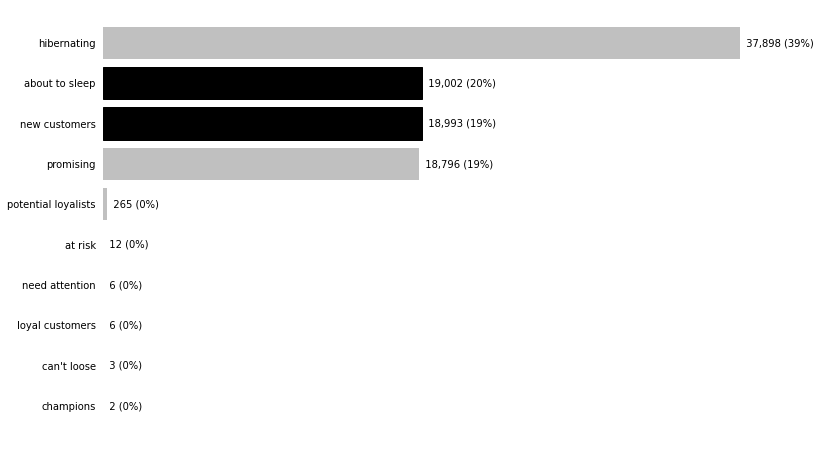

In [115]:
# Визуализирую верхнее дерево для наглядности
segments_counts = rfm_df['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(12,8))

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='Silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['about to sleep', 'new customers']:
            bar.set_color('Black')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '  {:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )
plt.show()

### Segmen ᅠ ᅠ ᅠ ᅠ ᅠᅠ  Description

**Champions**ᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠКупил недавно, покупает часто и тратьте больше всего

**Loyal Customers**ᅠᅠᅠᅠᅠᅠᅠПокупает на регулярной основе. Реагирует на рекламные акции.

**Potential Loyalist**ᅠᅠᅠᅠᅠᅠНедавний клиент со средней частотой.

**Recent Customers**ᅠᅠᅠᅠᅠᅠПокупает совсем недавно, но не часто.

**Promising**ᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠНедавние покупатель, но потратил немного.

**Needing Attention**ᅠᅠᅠᅠᅠНовый, частота и денежные показатели выше среднего. Возможно, покупка его не совсем недавняя.

**About To Sleep**ᅠᅠᅠᅠᅠᅠᅠНовый и частота ниже среднего. Он будет потерян, если не будет повторно активирован.

**At Risk**ᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠПриобретал часто, но очень давно. Нужно вернуть его обратно!

**Can’t Lose**ᅠᅠᅠᅠᅠᅠᅠᅠᅠРаньше часто покупал, но долгое время не возвращался.

**Hibernating**ᅠᅠᅠᅠᅠᅠᅠᅠᅠПоследняя покупка была давней и с низким количеством заказов. Может быть потерян.

У нас много клиентов, которые не часто покупают у нас (39% находятся в спящем режиме). Также примерно одинаковое кличество людей со статусами ***"About To Sleep"*** и ***"new customers"*** и их суммарный процент велик. Также недалеко ушли клиенты со статусом ***"Promising"***. Исходя из этого можно сделать вывод, что большенство клиентов в процессе пользования потеряли интерес, но суммарное количество новых клиентов и недавних покупателей дают надежду на поднятие активности.